In [126]:
# Add Heatwave Root to PYTHONPATH
import sys; sys.path.append('../..')

from heatwave import ERA, utils

import tensorflow as tf
import keras
from keras import Sequential
from keras.utils import Sequence
from keras.layers import *
from keras.regularizers import *
import keras_metrics as metric

from vis import visualization

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

from skimage import transform

import numpy as np
import pandas as pd

import os

In [2]:
DATA_ROOT = os.path.abspath("/Volumes/Samsung_T5/Thesis")
ERA_ROOT = os.path.join(DATA_ROOT, 'ERA')

In [3]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc
    
def plot_roc(y_true, y_predict):
    # Plot Receiver Operating Characteristic Curve with Area Under Curve Score
    fpr, tpr, thr = roc_curve(y_true, y_predict)
    auc = roc_auc_score(y_true, y_predict)

    plt.title(f"ROC Curve - AUC: {auc:5.5f}")
    plt.plot([0, 1], [0, 1], linestyle="--", c="gray")
    plt.plot(fpr, tpr)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("False Positive Ratio")
    plt.ylabel("True Positive Ratio")

In [4]:
def load_T95(path) -> pd.DataFrame:
    df = pd.read_csv(path, names=["date", "series"])

    # Set Date as Index
    df["date"] = pd.DatetimeIndex(df["date"])
    df = df.set_index("date")

    return df

T95 = load_T95(os.path.join(DATA_ROOT, 'heatwave.csv'))

In [120]:
LAG = 50
WINDOWS = [1]

SST_PATH = os.path.join(ERA_ROOT, 'sst_1979-2017_1_12_daily_2.5deg.nc')
SST = ERA(SST_PATH, 'sst', index=[None, slice(10, -15)])

ssts = []

for window in WINDOWS:
    sst = pd.DataFrame(SST.anomaly.reshape(len(SST.time), -1), index=SST.time.index).rolling(window).mean()
    sst = sst.loc[T95.index - pd.Timedelta(LAG, 'D')].values.reshape(len(T95.index), len(SST.latitude), len(SST.longitude))
#     sst = sst[:, 10:-15, :]  # Remove Polar Regions (resulting in a shape which can be divided by 2, 4 times)
    
    ssts.append(sst)
    
sst = np.concatenate([sst[..., None] for sst in ssts], axis=-1)
sst[np.isnan(sst)] = 0

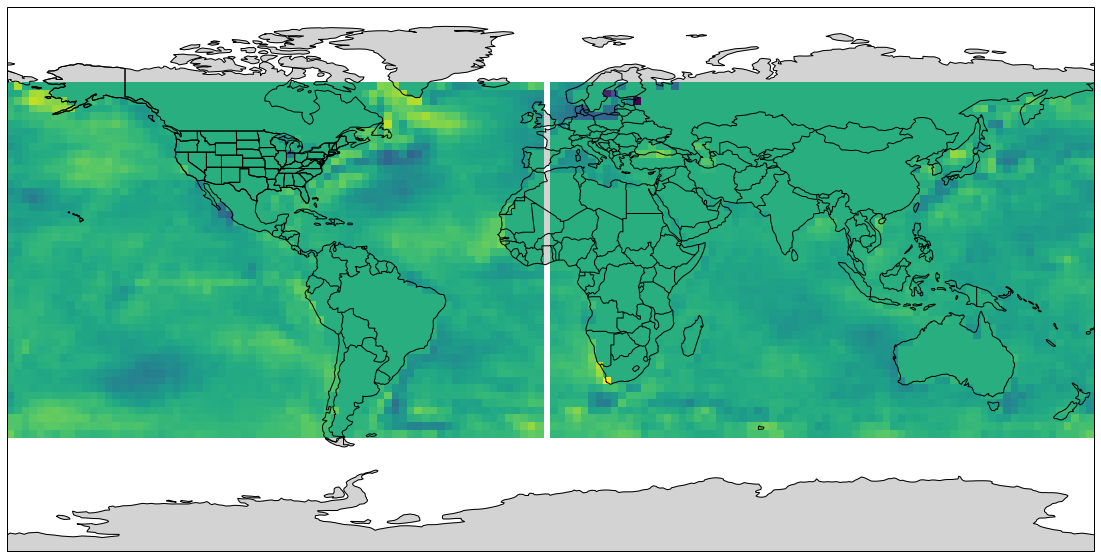

In [122]:
utils.plot_earth()
plt.pcolormesh(SST.longitude, SST.latitude, sst[0, ..., 0])
plt.show()

# Model

In [244]:
def model():
    
    ACTIVATION = tf.nn.relu
    PADDING = 'same'
    REGULARIZER = l2(0.02)
#     REGULARIZER = l1(0.01)
    KERNEL = 3
    FILTERS = 8

    CONV2D_KWARGS = {'padding': PADDING, 'kernel_regularizer': REGULARIZER}

    # Sequential Model
    model = Sequential()
    
    # Convolution Group Template
    def convolution(groups, filters, dropout):
        for group in range(groups):
            model.add(Conv2D(filters, KERNEL, **CONV2D_KWARGS))
            model.add(BatchNormalization())
            model.add(Activation(ACTIVATION))
          
        model.add(MaxPool2D(2))
        model.add(Dropout(dropout))
        

    # Specify Input Shape in 'Dummy Layer'
    model.add(Activation('linear', input_shape=(sst.shape[1:])))
    
    # Specify Convolution Groups
    convolution(groups=2, filters=FILTERS, dropout=0.1)
    convolution(groups=2, filters=FILTERS*2, dropout=0.2)
    convolution(groups=1, filters=FILTERS*4, dropout=0.3)
    convolution(groups=1, filters=FILTERS*8, dropout=0.4)

    # Flatten Image Space
    model.add(Flatten())
    
    # Fully Connected Layer
    model.add(Dense(200, kernel_regularizer=REGULARIZER))
    model.add(BatchNormalization())
    model.add(Activation(ACTIVATION))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(1, activation=tf.nn.sigmoid, name="output"))
    
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model

model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_252 (Activation)  (None, 48, 144, 1)        0         
_________________________________________________________________
conv2d_188 (Conv2D)          (None, 48, 144, 8)        80        
_________________________________________________________________
batch_normalization_220 (Bat (None, 48, 144, 8)        32        
_________________________________________________________________
activation_253 (Activation)  (None, 48, 144, 8)        0         
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 48, 144, 8)        584       
_________________________________________________________________
batch_normalization_221 (Bat (None, 48, 144, 8)        32        
_________________________________________________________________
activation_254 (Activation)  (None, 48, 144, 8)        0         
__________

# Train Test Split & Training CNN

In [245]:
k = 3

# Create k-Folds
X = np.split(sst, k)
Y = np.split((T95.values > 1), k)

for i in range(k):
    
    # Create Train/Test-Split for this Fold
    train_X = np.concatenate([X[j] for j in range(k) if j != i], axis=0)
    train_y = np.concatenate([Y[j] for j in range(k) if j != i], axis=0)
    
    test_X = X[i]
    test_y = Y[i]
    
    print(f"Fold {i+1} of {k}")
    print("Train", train_X.shape, train_y.shape)
    print("Test", test_X.shape, test_y.shape)
    
    class Callback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            print(" -> AUC:", roc_auc_score(train_y, self.model.predict(train_X)), roc_auc_score(test_y, self.model.predict(test_X)))
    
    m = model()
    m.fit(train_X, train_y, validation_data=(test_X, test_y), callbacks=[Callback()], shuffle=True, epochs=20)
    
    break  # Only train one fold for now!

Fold 1 of 3
Train (1560, 48, 144, 1) (1560, 1)
Test (780, 48, 144, 1) (780, 1)
Train on 1560 samples, validate on 780 samples
Epoch 1/20
1560/1560 [==============================] - 40s 26ms/step - loss: 7.3696 - val_loss: 5.6315
 -> AUC: 0.726994183631076 0.4306501425403864
Epoch 2/20
1560/1560 [==============================] - 16s 11ms/step - loss: 4.6062 - val_loss: 4.2336
 -> AUC: 0.7834084181553801 0.38741289198606266
Epoch 3/20
1560/1560 [==============================] - 16s 11ms/step - loss: 3.3705 - val_loss: 3.1985
 -> AUC: 0.8023797777316161 0.40893253088375037
Epoch 4/20
1560/1560 [==============================] - 16s 10ms/step - loss: 2.5985 - val_loss: 2.5944
 -> AUC: 0.8068686383464894 0.40236973392461195
Epoch 5/20
1560/1560 [==============================] - 17s 11ms/step - loss: 2.0496 - val_loss: 2.1990
 -> AUC: 0.7423205754050686 0.5088642302819132
Epoch 6/20
1560/1560 [==============================] - 18s 11ms/step - loss: 1.6904 - val_loss: 1.9351
 -> AUC: 0.75

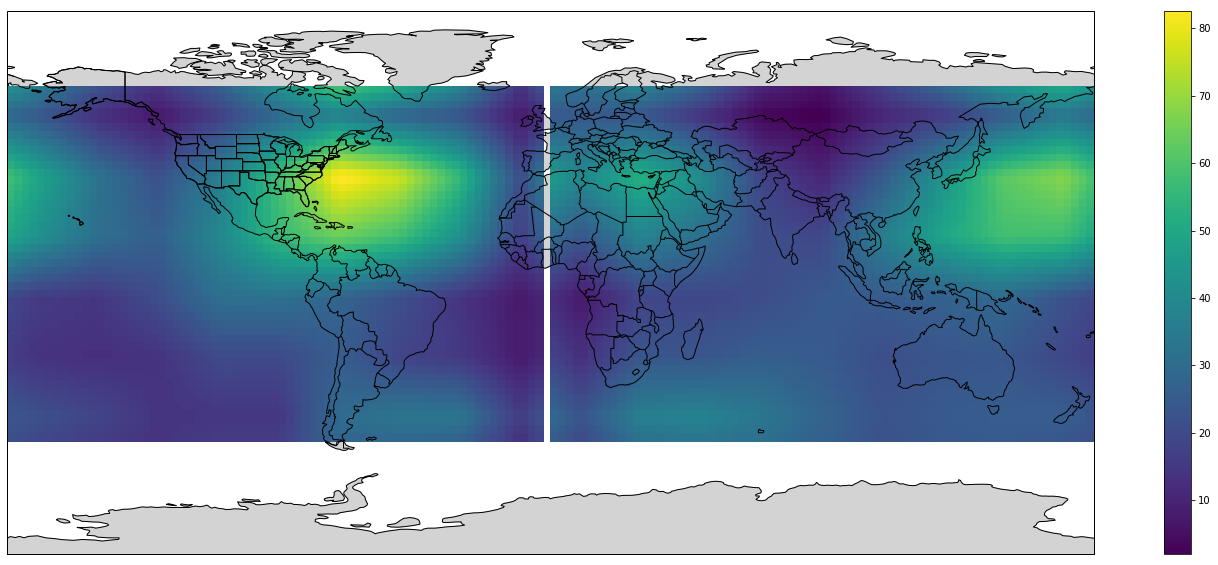

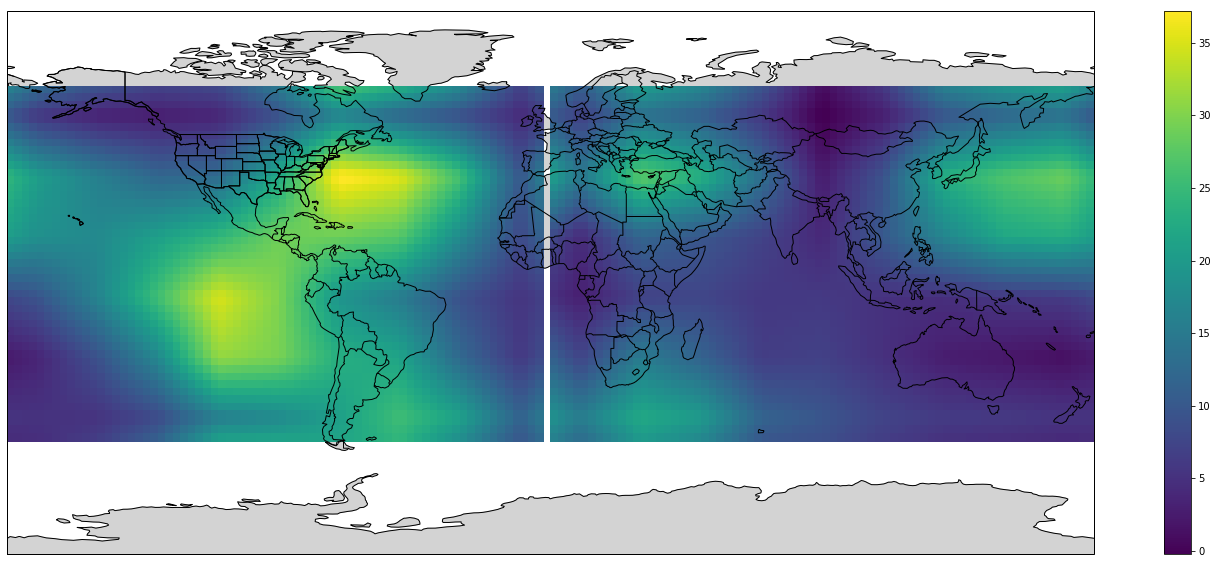

In [243]:
# Create Class Activation Map

def CAM(model, X):
    
    last_convolution = [layer for layer in model.layers if isinstance(layer, Conv2D)][-1]
    result = np.zeros(last_convolution.output.shape[1:-1])
    
    gradients = K.gradients(model.output, last_convolution.output)[0]
    gradients_mean = K.mean(gradients, axis=(0, 1, 2))
    iterate = K.function([model.input], [gradients_mean, last_convolution.output[0]])

    for counter, x in enumerate(X):
        activation, output = iterate([x[None, ...]])
        for i in range(gradients_mean.shape[0]):
            output[..., i] += activation[i]
            
        result += output.mean(-1)
    
    return transform.resize(result, X.shape[1:-1])

# Train Activation
utils.plot_earth()
plt.pcolormesh(SST.longitude, SST.latitude, CAM(m, train_X[train_y.ravel()]))
plt.colorbar()
plt.show()

# Test Activation
utils.plot_earth()
plt.pcolormesh(SST.longitude, SST.latitude, CAM(m, test_X[test_y.ravel()]))
plt.colorbar()
plt.show()